In [49]:
from imaster_paper_args import *

In [41]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import pyccl as ccl
import pymaster as nmt
import healpy as hp

import sys
sys.path.insert(0, '../skylens')
import correction

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cl_theory = {
    i: np.loadtxt(f'../data/cl_{i}_{i}.txt')[1] for i in range(4)
}

In [4]:
with open('../data/bu.pickle', 'rb') as f:
    bu = pickle.load(f)
    
with open('../data/M.pickle', 'rb') as f:
    SL = pickle.load(f)

In [5]:
nside = 1024
ell = np.arange(3*nside)

In [6]:
#setup parameters
lmax_cl = 2200 #2000
lmin_cl = 0

l0 = np.arange(lmin_cl, lmax_cl)

window_lmax = lmax_cl

lmin_cl_Bins = 200 #lmin_cl+2
lmax_cl_Bins = lmax_cl - 10
Nl_bins = 16

#l_bins = np.unique(np.int64(np.logspace(np.log10(lmin_cl_Bins), np.log10(lmax_cl_Bins), Nl_bins+1)))
#l_bins = np.arange(lmin_cl_Bins, lmax_cl_Bins, Nl_bins)
l_bins = np.linspace(lmin_cl_Bins, lmax_cl_Bins, Nl_bins)
lb = .5 * (l_bins[1:] + l_bins[:-1])
dl = (l_bins[1:] - l_bins[:-1])
lb_cl = lb * 1.
l_bins_center = lb * 1.
Nl_bins = len(lb)

l = l0

In [7]:
sigma_e = 0.25
arcmin2rad = 1 / 60 * (np.pi / 180)
n_source = 12 
noise_cl = sigma_e ** 2 / n_source * arcmin2rad ** 2
noise_cl = noise_cl * np.ones_like(cl_theory[0])

In [8]:
pcl_t_ee = np.zeros((100, 4, 3*nside))
pcl_t_bb = np.zeros((100, 4, 3*nside))
for i in range(100):
    fname = f'../sims/pcl_{i}_eb_with_noise.pickle'
    with open(fname, 'rb') as f:
         d = pickle.load(f)
    for b in range(4):
        pcl_t_ee[i][b] = d[b][1]
        pcl_t_bb[i][b] = d[b][2]

In [9]:
def bin_2d_coupling(
        M=[],
        bin_utils=None,
        wt_b=None,
        wt0=None,
        partial_bin_side=None,
        lm=0,
        lm_step=-1,
        cov=False,
    ):  # asymmetric binning
        ndim = 1
        if cov:
            ndim = 2
        binning_mat = bin_utils["binning_mat"]

        if len(wt0.shape) == 1:
            binning_mat2 = wt0[:, None] * binning_mat * wt_b
        else:
            binning_mat2 = (
                wt0 @ binning_mat @ wt_b
            )  # FIXME: Test this.... doesnot work. not used anymore.

        #         rdr=bin_utils['r_dr']
        #         r_dr_m=bin_utils['r_dr_m'][ndim]
        #         binning_mat=binning_mat*rdr[:,None]/bin_utils['norm'][None,:]

        binning_mat = bin_utils["binning_mat_r_dr"]
        if partial_bin_side is None:
            cov_b = binning_mat.T @ M @ binning_mat2
        elif partial_bin_side == 1:
            cov_b = binning_mat.T @ M @ binning_mat2[lm : lm + lm_step, :]
        elif partial_bin_side == 2:
            cov_b = binning_mat[lm : lm + lm_step, :].T @ M @ binning_mat2

        #         cov_b/=bin_utils['norm_m'][1][:,None]
        return cov_b

    
def bin_1d(xi=[], bin_utils=None):
    xi_b = jnp.dot(xi * bin_utils["r_dr"], bin_utils["binning_mat"])
    xi_b /= bin_utils["norm"]
    return xi_b

In [10]:
cl_sl_ee_binned = dict()
cl_sl_bb_binned = dict()
cl_theory_ee_binned = dict()
cl_theory_bb_binned = dict()

for n in range(100):
    cl_sl_ee_binned[n] = dict()
    cl_sl_bb_binned[n] = dict()
    for i in range(4):
        bi = (i, i)
        M = SL[bi]['M']
        M_noise = SL[bi]['M_noise']
        M_b = SL[bi]['M_B']
        M_b_noise = SL[bi]['M_B_noise']
        
        pcl_ee_n = noise_cl[:lmax_cl] @ M_noise + (0.1 * noise_cl[:lmax_cl]) @ M_b_noise
        pcl_bb_n = (0.1 * noise_cl[:lmax_cl]) @ M_noise + noise_cl[:lmax_cl] @ M_b_noise
        
        pcl_ee = pcl_t_ee[n][i][:lmax_cl] - pcl_ee_n
        pcl_bb = pcl_t_bb[n][i][:lmax_cl] - pcl_bb_n

        pcl_ee_binned = bin_1d(pcl_ee, bin_utils=bu)
        pcl_bb_binned = bin_1d(pcl_bb, bin_utils=bu)
        cl_ee_binned = bin_1d(cl_theory[i][:lmax_cl], bin_utils=bu)
        cl_bb_binned = bin_1d(0.1 * cl_theory[i][:lmax_cl], bin_utils=bu)

        cl_theory_ee_binned[i] = cl_ee_binned
        cl_theory_bb_binned[i] = cl_bb_binned

        wt0_ee = 1. / cl_theory[i][:lmax_cl]
        wt0_ee[0] = 0
        wt0_bb = 1. / (0.1 * cl_theory[i][:lmax_cl])
        wt0_bb[0] = 0

        Mp_ee_binned = bin_2d_coupling(M=M, bin_utils=bu, wt_b=cl_ee_binned, wt0=wt0_ee)
        Mp_bb_binned = bin_2d_coupling(M=M, bin_utils=bu, wt_b=cl_bb_binned, wt0=wt0_bb)

        Mn_ee_binned = bin_2d_coupling(M=M_b, bin_utils=bu, wt_b=cl_ee_binned, wt0=wt0_ee)
        Mn_bb_binned = bin_2d_coupling(M=M_b, bin_utils=bu, wt_b=cl_bb_binned, wt0=wt0_bb)
        

        cl_sl_ee_binned[n][i] = pcl_ee_binned @ np.linalg.pinv(Mp_ee_binned) - cl_bb_binned @ (np.linalg.pinv(Mp_ee_binned) @ Mn_bb_binned)
        cl_sl_bb_binned[n][i] = pcl_bb_binned @ np.linalg.pinv(Mp_bb_binned) - cl_ee_binned @ (np.linalg.pinv(Mp_bb_binned) @ Mn_ee_binned)

/tmp/ipykernel_2614036/3310766123.py:30: RuntimeWarning: divide by zero encountered in true_divide
  wt0_ee = 1. / cl_theory[i][:lmax_cl]
/tmp/ipykernel_2614036/3310766123.py:32: RuntimeWarning: divide by zero encountered in true_divide
  wt0_bb = 1. / (0.1 * cl_theory[i][:lmax_cl])


In [11]:
cl_sl_t_ee_binned = np.zeros((100, 4, Nl_bins))
cl_sl_t_bb_binned = np.zeros((100, 4, Nl_bins))
for i in range(100):
    for b in range(4):
        cl_sl_t_ee_binned[i][b] = cl_sl_ee_binned[i][b]
        cl_sl_t_bb_binned[i][b] = cl_sl_bb_binned[i][b]

In [12]:
cl_sl_ee_binned_mean = np.mean(cl_sl_t_ee_binned, axis=0)
cl_sl_ee_binned_std = np.std(cl_sl_t_ee_binned, axis=0)
cl_sl_bb_binned_mean = np.mean(cl_sl_t_bb_binned, axis=0)
cl_sl_bb_binned_std = np.std(cl_sl_t_bb_binned, axis=0)

<Figure size 2160x864 with 0 Axes>

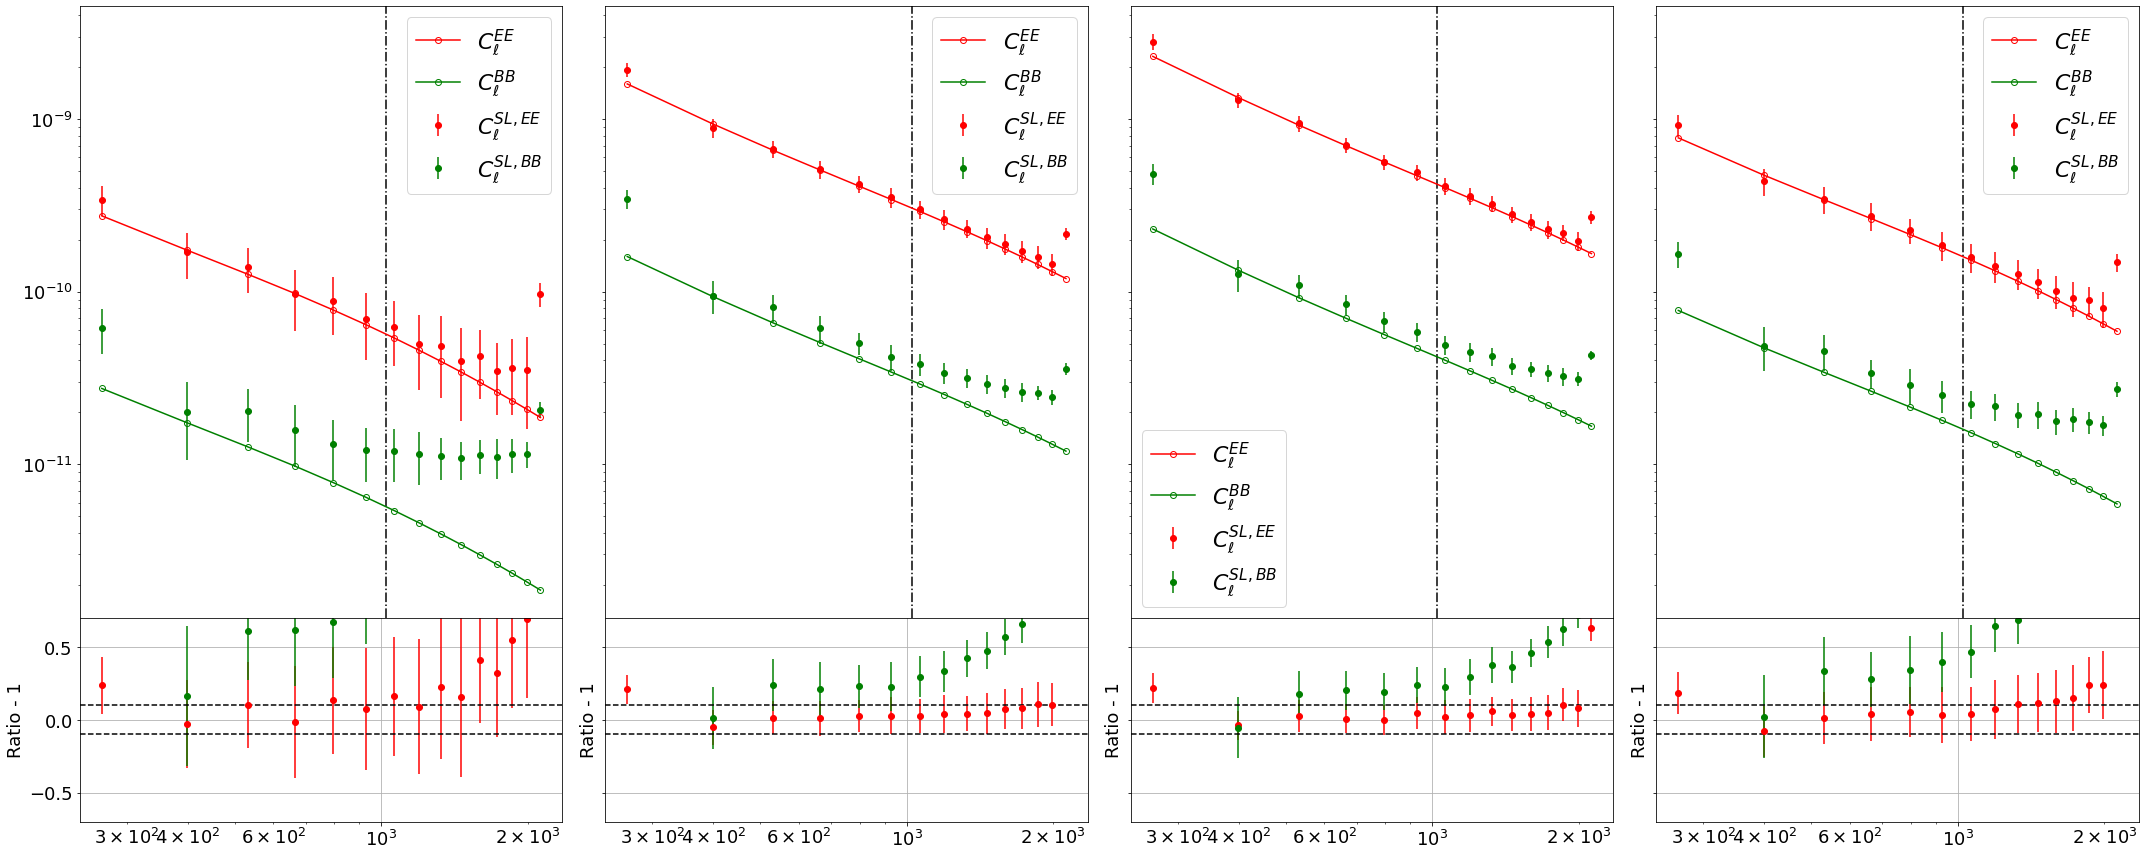

In [14]:
bc = 0.5 * (l_bins[1:] + l_bins[:-1])
fig = plt.figure(figsize=(30, 12))
fig, axs = plt.subplots(nrows=2, ncols=4, sharey='row', sharex=True,
                       gridspec_kw={'height_ratios': [3, 1], 'hspace': 0},
                       figsize=(30, 12))
for i in range(4):
    ax0, ax1 = axs[0, i], axs[1, i]
    ax0.errorbar(bc, cl_sl_ee_binned_mean[i], cl_sl_ee_binned_std[i], fmt='o', ls='None', label=r'$C_\ell^{SL, EE}$', c='red')
    ax0.errorbar(bc, cl_sl_bb_binned_mean[i], cl_sl_bb_binned_std[i], fmt='o', ls='None', label=r'$C_\ell^{SL, BB}$', c='green')
    ax0.axvline(x=nside, c='black', ls='-.')

    ax0.loglog(bc, cl_theory_ee_binned[i], 'o', ls='-', label=r'$C_\ell^{EE}$', c='red', fillstyle='none')
    ax0.loglog(bc, cl_theory_bb_binned[i], 'o', ls='-', label=r'$C_\ell^{BB}$', c='green', fillstyle='none')

    ax0.tick_params(axis='both', which='major', labelsize=18)
    ax0.tick_params(axis='both', which='minor', labelsize=18)
    ax0.label_outer()
    ax0.legend(fontsize=22)
    
    #ax1.semilogx(bc, pcl_bb_binned_mean[i] / cl_bb_binned[i] - 1, 'o', label='BB', c='green')
    #ax1.semilogx(bc, pcl_ee_binned_mean[i] / cl_ee_binned[i] - 1, 'v', label='EE', c='red')
    ax1.errorbar(bc, cl_sl_ee_binned_mean[i] / cl_theory_ee_binned[i] - 1, cl_sl_ee_binned_std[i] / cl_sl_ee_binned_mean[i], fmt='o', c='red')
    ax1.errorbar(bc, cl_sl_bb_binned_mean[i] / cl_theory_bb_binned[i] - 1, cl_sl_bb_binned_std[i] / cl_sl_bb_binned_mean[i], fmt='o', c='green')
    #ax1.errorbar(bc, pcl_t_bb_binned[0][i] / cl_bb_binned[i] - 1, pcl_bb_binned_std[i] / pcl_t_bb_binned[0][i], fmt='o', c='green')
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.set_ylim(-0.7, 0.7)
    ax1.axhline(0.1, c='black', ls='--')
    ax1.axhline(-0.1, c='black', ls='--')
    ax1.set_ylabel('Ratio - 1', fontsize=18)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.tick_params(axis='both', which='minor', labelsize=18)
    #ax1.legend()
plt.tight_layout()

# Noise only

In [15]:
pcl_t_ee = np.zeros((100, 4, 3*nside))
pcl_t_bb = np.zeros((100, 4, 3*nside))
for i in range(100):
    fname = f'../sims/pcl_{i}_eb_with_noise_only.pickle'
    with open(fname, 'rb') as f:
         d = pickle.load(f)
    for b in range(4):
        pcl_t_ee[i][b] = d[b][1]
        pcl_t_bb[i][b] = d[b][2]

In [16]:
pcl_t_ee_mean = np.mean(pcl_t_ee, axis=0)
pcl_t_bb_mean = np.mean(pcl_t_bb, axis=0)

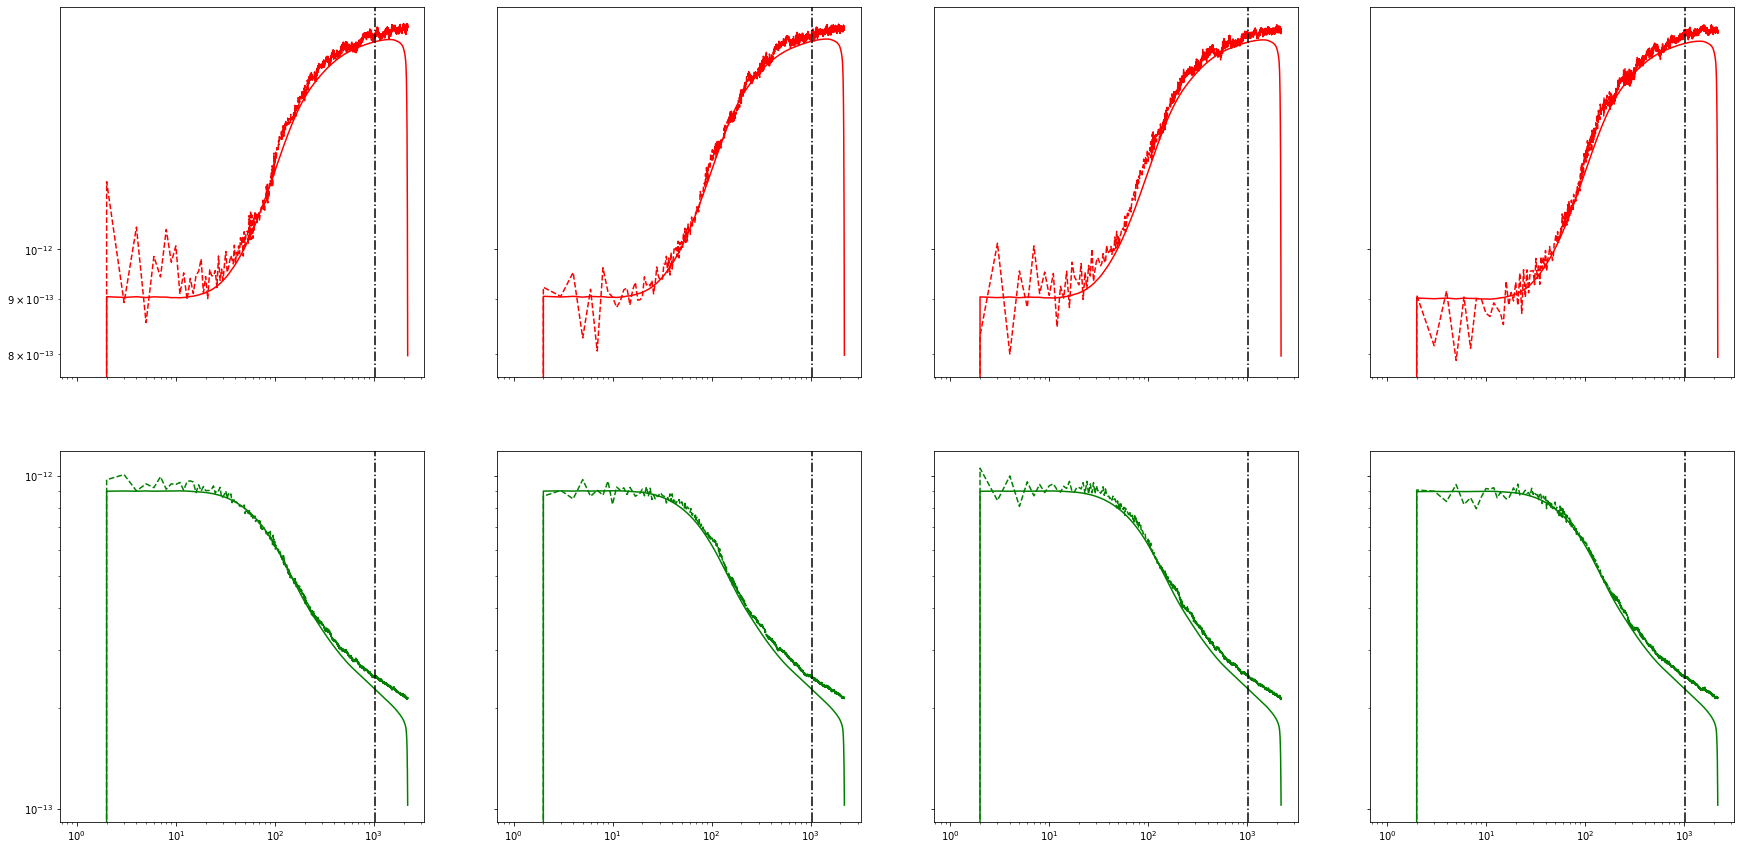

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(30, 15), sharey='row', sharex=True)
noise_cl_ee = noise_cl * 1.
noise_cl_bb = (0.1 * noise_cl) * 1.
for i in range(4):
    bi = (i, i)
    M_noise = SL[bi]['M_noise']
    M_b_noise = SL[bi]['M_B_noise']
    
    Dl_ee = noise_cl_ee[:lmax_cl] @ M_noise + noise_cl_bb[:lmax_cl] @ M_b_noise
    Dl_bb = noise_cl_bb[:lmax_cl] @ M_noise + noise_cl_ee[:lmax_cl] @ M_b_noise
    
    axs[0, i].loglog(ell[:lmax_cl], pcl_t_ee_mean[i][:lmax_cl], c='red', ls='--')
    axs[0, i].loglog(ell[:lmax_cl], Dl_ee, c='red')
    axs[0, i].axvline(nside, c='black', ls='-.')
    
    axs[1, i].loglog(ell[:lmax_cl], pcl_t_bb_mean[i][:lmax_cl], c='green', ls='--')
    axs[1, i].loglog(ell[:lmax_cl], Dl_bb, c='green')
    axs[1, i].axvline(nside, c='black', ls='-.')

# N_l = 0 for l > l_max

In [19]:
pcl_t_ee = np.zeros((100, 4, 3*nside))
pcl_t_bb = np.zeros((100, 4, 3*nside))
for i in range(100):
    fname = f'../sims/pcl_{i}_eb_with_noise_only_2200.pickle'
    with open(fname, 'rb') as f:
         d = pickle.load(f)
    for b in range(4):
        pcl_t_ee[i][b] = d[b][1]
        pcl_t_bb[i][b] = d[b][2]

In [20]:
pcl_t_ee_mean = np.mean(pcl_t_ee, axis=0)
pcl_t_bb_mean = np.mean(pcl_t_bb, axis=0)

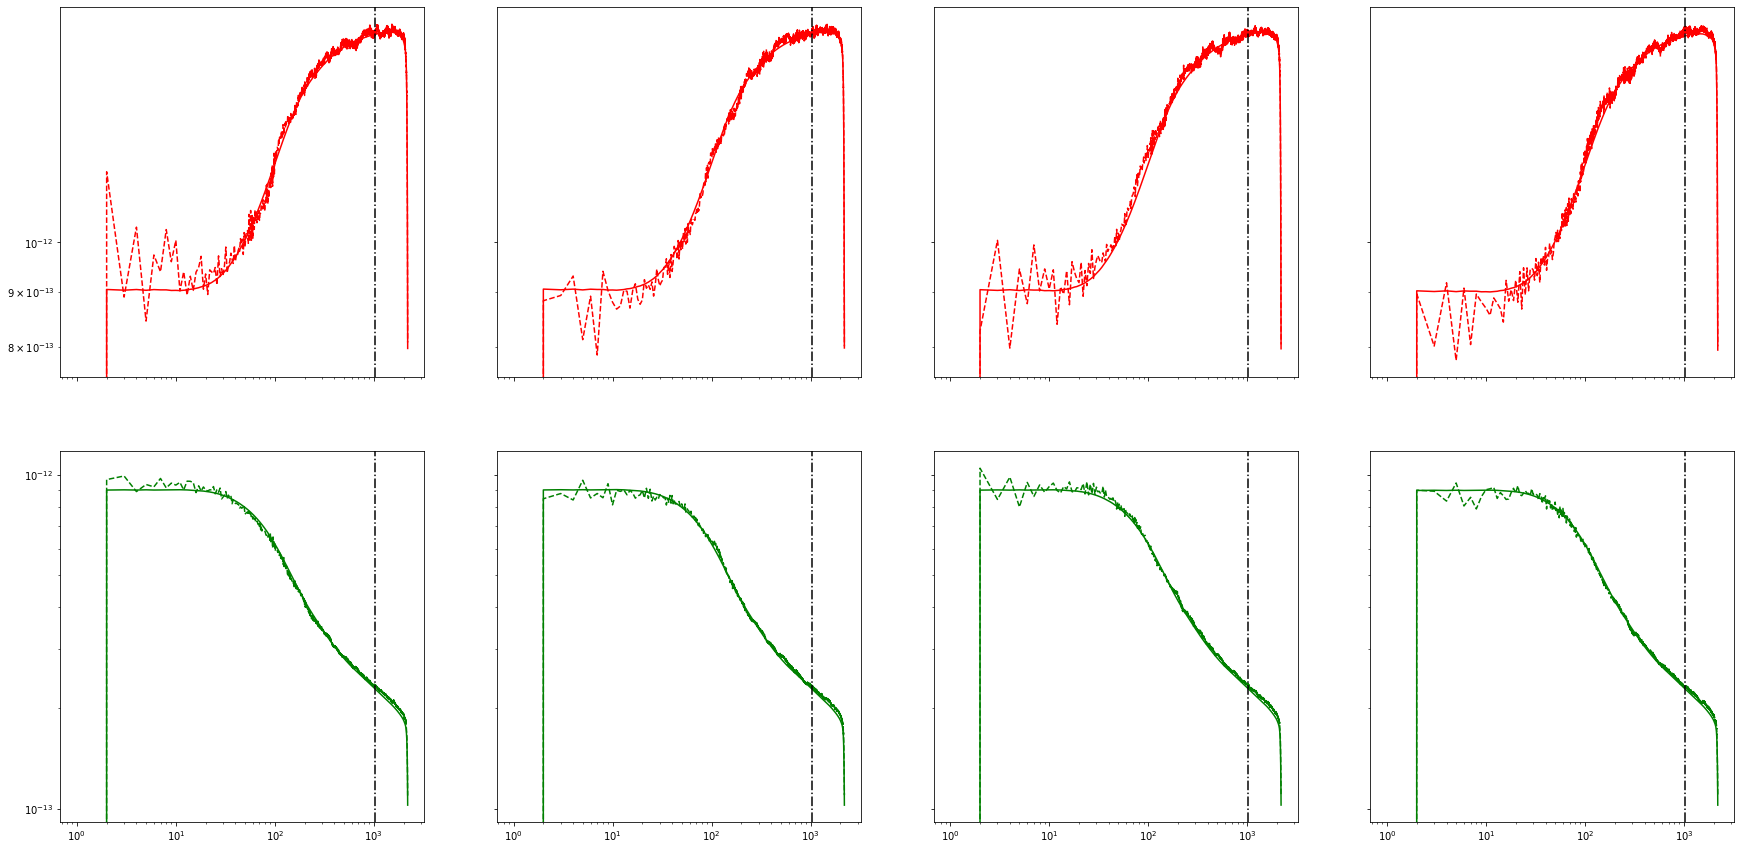

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(30, 15), sharey='row', sharex=True)
noise_cl_ee = noise_cl * 1.
noise_cl_bb = (0.1 * noise_cl) * 1.
for i in range(4):
    bi = (i, i)
    M_noise = SL[bi]['M_noise']
    M_b_noise = SL[bi]['M_B_noise']
    
    Dl_ee = noise_cl_ee[:lmax_cl] @ M_noise + noise_cl_bb[:lmax_cl] @ M_b_noise
    Dl_bb = noise_cl_bb[:lmax_cl] @ M_noise + noise_cl_ee[:lmax_cl] @ M_b_noise
    
    axs[0, i].loglog(ell[:lmax_cl], pcl_t_ee_mean[i][:lmax_cl], c='red', ls='--')
    axs[0, i].loglog(ell[:lmax_cl], Dl_ee, c='red')
    axs[0, i].axvline(nside, c='black', ls='-.')
    
    axs[1, i].loglog(ell[:lmax_cl], pcl_t_bb_mean[i][:lmax_cl], c='green', ls='--')
    axs[1, i].loglog(ell[:lmax_cl], Dl_bb, c='green')
    axs[1, i].axvline(nside, c='black', ls='-.')

In [35]:
pcl_t_ee = np.zeros((100, 4, 3*nside))
pcl_t_bb = np.zeros((100, 4, 3*nside))
for i in range(100):
    fname = f'../sims/pcl_{i}_eb_with_noise_2200.pickle'
    with open(fname, 'rb') as f:
         d = pickle.load(f)
    for b in range(4):
        pcl_t_ee[i][b] = d[b][1]
        pcl_t_bb[i][b] = d[b][2]

In [36]:
cl_sl_ee_binned = dict()
cl_sl_bb_binned = dict()
cl_theory_ee_binned = dict()
cl_theory_bb_binned = dict()

for n in range(100):
    cl_sl_ee_binned[n] = dict()
    cl_sl_bb_binned[n] = dict()
    for i in range(4):
        bi = (i, i)
        M = SL[bi]['M']
        M_noise = SL[bi]['M_noise']
        M_b = SL[bi]['M_B']
        M_b_noise = SL[bi]['M_B_noise']
        
        pcl_ee_n = noise_cl[:lmax_cl] @ M_noise + (0.1 * noise_cl[:lmax_cl]) @ M_b_noise
        pcl_bb_n = (0.1 * noise_cl[:lmax_cl]) @ M_noise + noise_cl[:lmax_cl] @ M_b_noise
        
        pcl_ee = pcl_t_ee[n][i][:lmax_cl] - pcl_ee_n
        pcl_bb = pcl_t_bb[n][i][:lmax_cl] - pcl_bb_n

        pcl_ee_binned = bin_1d(pcl_ee, bin_utils=bu)
        pcl_bb_binned = bin_1d(pcl_bb, bin_utils=bu)
        cl_ee_binned = bin_1d(cl_theory[i][:lmax_cl], bin_utils=bu)
        cl_bb_binned = bin_1d(0.1 * cl_theory[i][:lmax_cl], bin_utils=bu)

        cl_theory_ee_binned[i] = cl_ee_binned
        cl_theory_bb_binned[i] = cl_bb_binned

        wt0_ee = 1. / cl_theory[i][:lmax_cl]
        wt0_ee[0] = 0
        wt0_bb = 1. / (0.1 * cl_theory[i][:lmax_cl])
        wt0_bb[0] = 0

        Mp_ee_binned = bin_2d_coupling(M=M, bin_utils=bu, wt_b=cl_ee_binned, wt0=wt0_ee)
        Mp_bb_binned = bin_2d_coupling(M=M, bin_utils=bu, wt_b=cl_bb_binned, wt0=wt0_bb)

        Mn_ee_binned = bin_2d_coupling(M=M_b, bin_utils=bu, wt_b=cl_ee_binned, wt0=wt0_ee)
        Mn_bb_binned = bin_2d_coupling(M=M_b, bin_utils=bu, wt_b=cl_bb_binned, wt0=wt0_bb)
        

        cl_sl_ee_binned[n][i] = pcl_ee_binned @ np.linalg.pinv(Mp_ee_binned) - cl_bb_binned @ (np.linalg.pinv(Mp_ee_binned) @ Mn_bb_binned)
        cl_sl_bb_binned[n][i] = pcl_bb_binned @ np.linalg.pinv(Mp_bb_binned) - cl_ee_binned @ (np.linalg.pinv(Mp_bb_binned) @ Mn_ee_binned)

/tmp/ipykernel_2614036/3310766123.py:30: RuntimeWarning: divide by zero encountered in true_divide
  wt0_ee = 1. / cl_theory[i][:lmax_cl]
/tmp/ipykernel_2614036/3310766123.py:32: RuntimeWarning: divide by zero encountered in true_divide
  wt0_bb = 1. / (0.1 * cl_theory[i][:lmax_cl])


In [37]:
cl_sl_t_ee_binned = np.zeros((100, 4, Nl_bins))
cl_sl_t_bb_binned = np.zeros((100, 4, Nl_bins))
for i in range(100):
    for b in range(4):
        cl_sl_t_ee_binned[i][b] = cl_sl_ee_binned[i][b]
        cl_sl_t_bb_binned[i][b] = cl_sl_bb_binned[i][b]

In [38]:
cl_sl_ee_binned_mean = np.mean(cl_sl_t_ee_binned, axis=0)
cl_sl_ee_binned_std = np.std(cl_sl_t_ee_binned, axis=0)
cl_sl_bb_binned_mean = np.mean(cl_sl_t_bb_binned, axis=0)
cl_sl_bb_binned_std = np.std(cl_sl_t_bb_binned, axis=0)

<Figure size 2160x864 with 0 Axes>

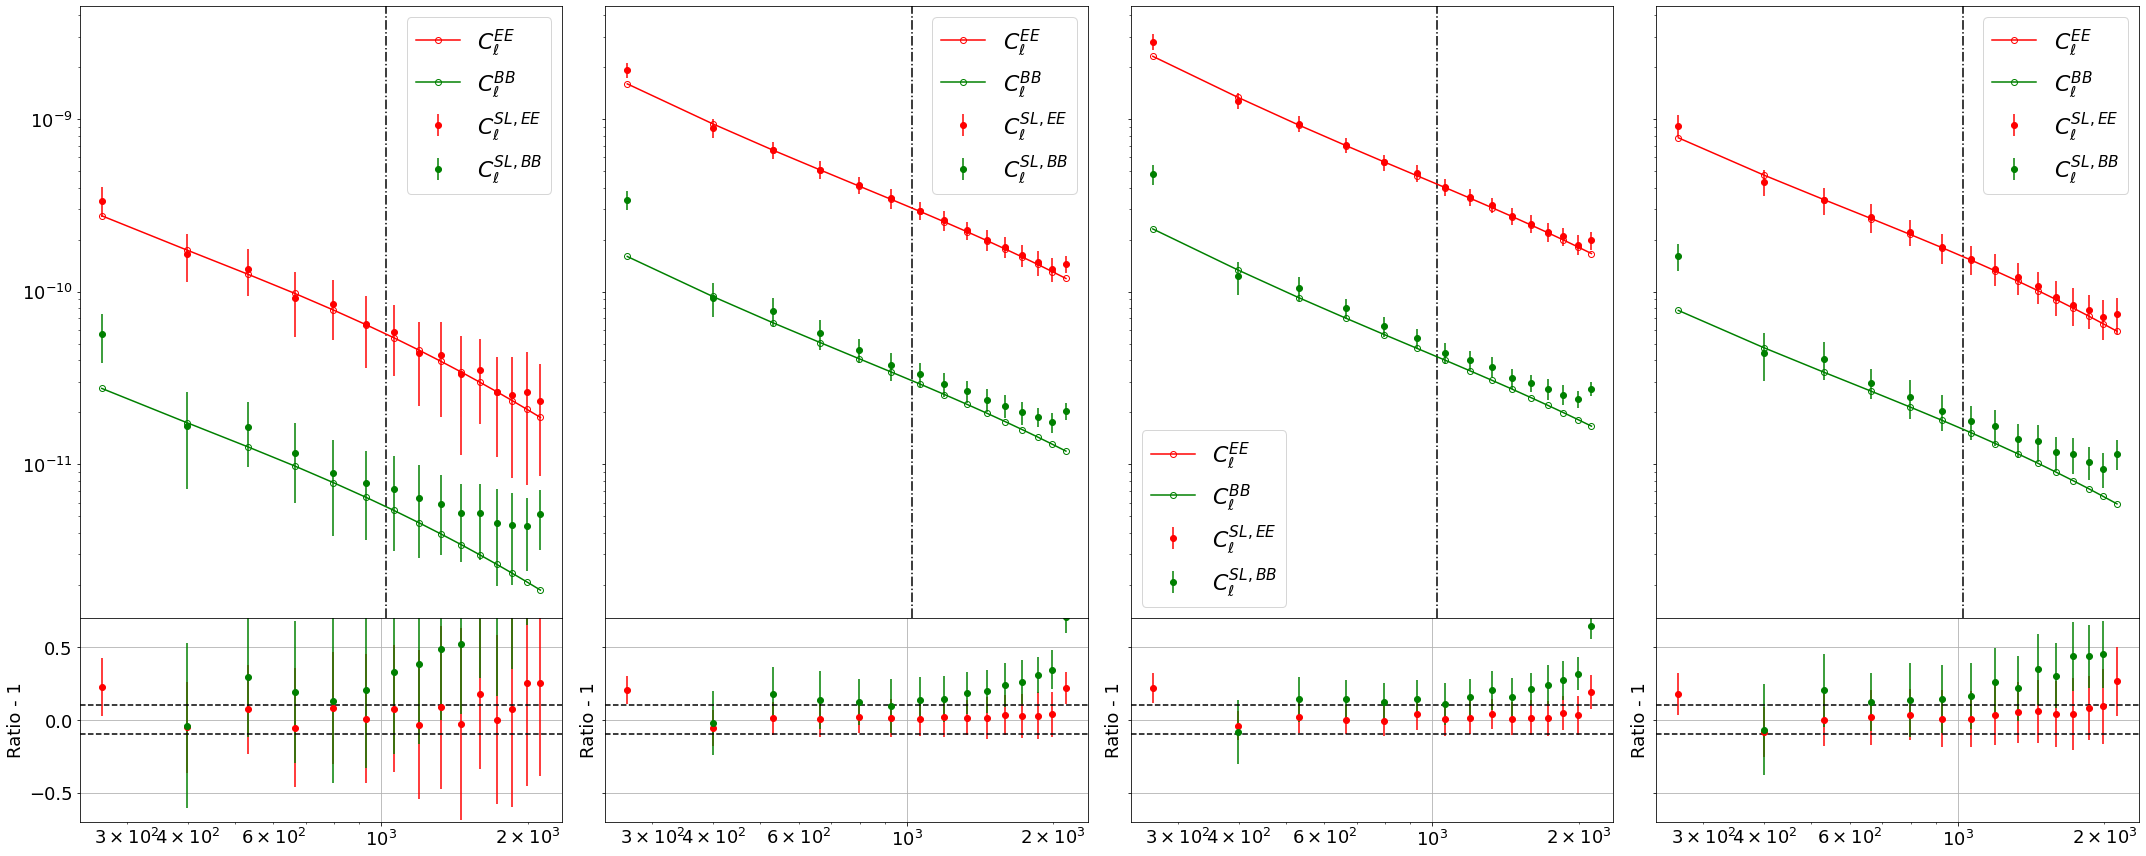

In [39]:
bc = 0.5 * (l_bins[1:] + l_bins[:-1])
fig = plt.figure(figsize=(30, 12))
fig, axs = plt.subplots(nrows=2, ncols=4, sharey='row', sharex=True,
                       gridspec_kw={'height_ratios': [3, 1], 'hspace': 0},
                       figsize=(30, 12))
for i in range(4):
    ax0, ax1 = axs[0, i], axs[1, i]
    ax0.errorbar(bc, cl_sl_ee_binned_mean[i], cl_sl_ee_binned_std[i], fmt='o', ls='None', label=r'$C_\ell^{SL, EE}$', c='red')
    ax0.errorbar(bc, cl_sl_bb_binned_mean[i], cl_sl_bb_binned_std[i], fmt='o', ls='None', label=r'$C_\ell^{SL, BB}$', c='green')
    ax0.axvline(x=nside, c='black', ls='-.')

    ax0.loglog(bc, cl_theory_ee_binned[i], 'o', ls='-', label=r'$C_\ell^{EE}$', c='red', fillstyle='none')
    ax0.loglog(bc, cl_theory_bb_binned[i], 'o', ls='-', label=r'$C_\ell^{BB}$', c='green', fillstyle='none')

    ax0.tick_params(axis='both', which='major', labelsize=18)
    ax0.tick_params(axis='both', which='minor', labelsize=18)
    ax0.label_outer()
    ax0.legend(fontsize=22)
    
    #ax1.semilogx(bc, pcl_bb_binned_mean[i] / cl_bb_binned[i] - 1, 'o', label='BB', c='green')
    #ax1.semilogx(bc, pcl_ee_binned_mean[i] / cl_ee_binned[i] - 1, 'v', label='EE', c='red')
    ax1.errorbar(bc, cl_sl_ee_binned_mean[i] / cl_theory_ee_binned[i] - 1, cl_sl_ee_binned_std[i] / cl_sl_ee_binned_mean[i], fmt='o', c='red')
    ax1.errorbar(bc, cl_sl_bb_binned_mean[i] / cl_theory_bb_binned[i] - 1, cl_sl_bb_binned_std[i] / cl_sl_bb_binned_mean[i], fmt='o', c='green')
    #ax1.errorbar(bc, pcl_t_bb_binned[0][i] / cl_bb_binned[i] - 1, pcl_bb_binned_std[i] / pcl_t_bb_binned[0][i], fmt='o', c='green')
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.set_ylim(-0.7, 0.7)
    ax1.axhline(0.1, c='black', ls='--')
    ax1.axhline(-0.1, c='black', ls='--')
    ax1.set_ylabel('Ratio - 1', fontsize=18)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.tick_params(axis='both', which='minor', labelsize=18)
    #ax1.legend()
plt.tight_layout()

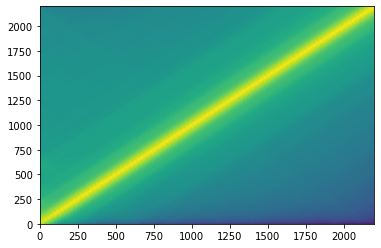

In [29]:
from matplotlib.colors import LogNorm
plt.pcolor(SL[bi]['M'], norm=LogNorm())

# No E/B

In [74]:
pcl_t = np.zeros((100, 4, 3*nside))
for i in range(100):
    fname = f'../sims/pcl_{i}_with_noise.pickle'
    with open(fname, 'rb') as f:
         d = pickle.load(f)
    for b in range(4):
        pcl_t[i][b] = d[b][1]
        
pcl_noise = np.zeros((100, 4, 3*nside))
for i in range(100):
    fname = f'../sims/pcl_{i}_noise.pickle'
    with open(fname, 'rb') as f:
         d = pickle.load(f)
    for b in range(4):
        pcl_noise[i][b] = d[b][1]

In [82]:
# HSC coverage is 1400 sq deg.
full_sky = 4 * np.pi * (180 / np.pi) ** 2
f_sky = 137. / (full_sky)

In [78]:
pcl_noise_t = np.zeros((100, 4, len(ell)))
for i in range(100):
    for b in range(4):
        pcl_noise_t[i][b] = pcl_noise[i][b]
pcl_noise_mean = np.mean(pcl_noise_t, axis=0)
pcl_noise_std = np.std(pcl_noise_t, axis=0)

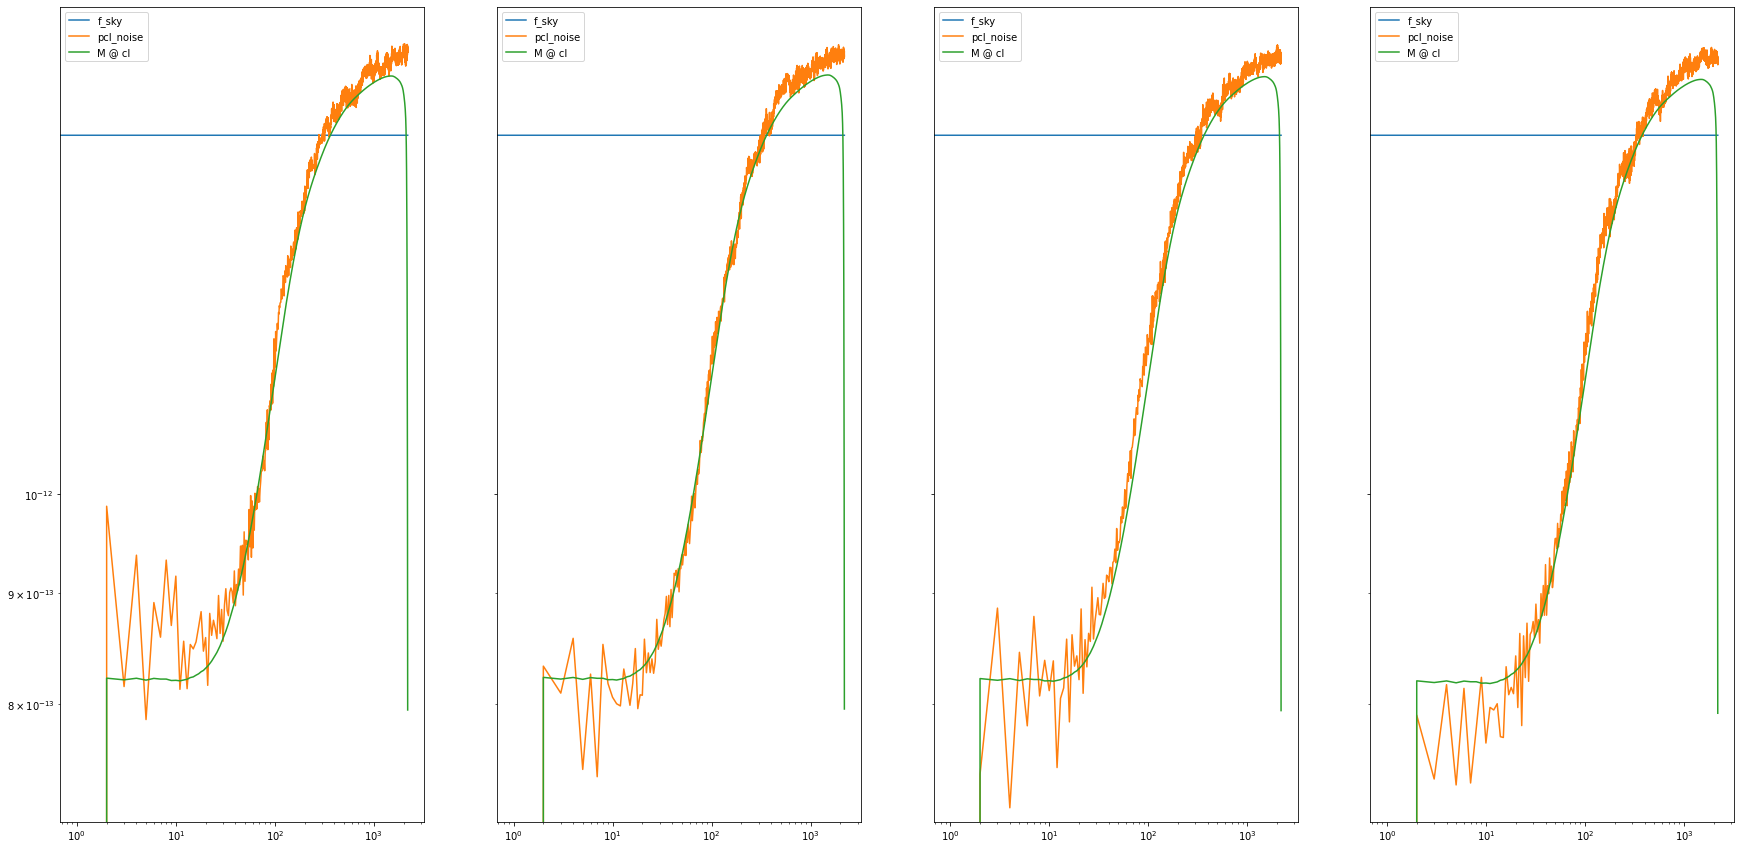

In [84]:
fig, axs = plt.subplots(nrows=1, ncols=4, sharey='row', sharex=True, figsize=(30, 15))
for i in range(4):
    axs[i].loglog(ell[:lmax_cl], f_sky * noise_cl[:lmax_cl], label='f_sky')
    axs[i].loglog(ell[:lmax_cl], pcl_noise_mean[i][:lmax_cl], label='pcl_noise')
    axs[i].loglog(ell[:lmax_cl], noise_cl[:lmax_cl] @ SL[(i, i)]['M_noise'], label='M @ cl')
    axs[i].legend()

In [86]:
cl_sl_binned = dict()
cl_theory_binned = dict()

for n in range(100):
    cl_sl_binned[n] = dict()
    for i in range(4):
        bi = (i, i)
        M = SL[bi]['M']
        M_noise = SL[bi]['M_noise']
        #pcl_n = noise_cl[:lmax_cl] @ M_noise
        pcl_n = f_sky * noise_cl[:lmax_cl]
        pcl = pcl_t[n][i][:lmax_cl] - pcl_n
        pcl_binned = bin_1d(pcl, bin_utils=bu)
        cl_binned = bin_1d(cl_theory[i][:lmax_cl], bin_utils=bu)

        cl_theory_binned[i] = cl_binned

        wt0 = 1. / cl_theory[i][:lmax_cl]
        wt0[0] = 0

        M_binned = bin_2d_coupling(M=M, bin_utils=bu, wt_b=cl_binned, wt0=wt0)

        cl_sl_binned[n][i] = pcl_binned @ np.linalg.pinv(M_binned) 

/tmp/ipykernel_2614036/3828363382.py:18: RuntimeWarning: divide by zero encountered in true_divide
  wt0 = 1. / cl_theory[i][:lmax_cl]


In [94]:
cl_sl_binned_c = dict()
cl_theory_binned = dict()

for n in range(100):
    cl_sl_binned_c[n] = dict()
    for i in range(4):
        bi = (i, i)
        M = SL[bi]['M']
        M_noise = SL[bi]['M_noise']
        pcl_n = noise_cl[:lmax_cl] @ M_noise
        #pcl_n = f_sky * noise_cl[:lmax_cl]
        pcl = pcl_t[n][i][:lmax_cl] - pcl_n
        pcl_binned = bin_1d(pcl, bin_utils=bu)
        cl_binned = bin_1d(cl_theory[i][:lmax_cl], bin_utils=bu)

        cl_theory_binned[i] = cl_binned

        wt0 = 1. / cl_theory[i][:lmax_cl]
        wt0[0] = 0

        M_binned = bin_2d_coupling(M=M, bin_utils=bu, wt_b=cl_binned, wt0=wt0)

        cl_sl_binned_c[n][i] = pcl_binned @ np.linalg.pinv(M_binned) 

/tmp/ipykernel_2614036/2131896158.py:18: RuntimeWarning: divide by zero encountered in true_divide
  wt0 = 1. / cl_theory[i][:lmax_cl]


In [87]:
cl_sl_t_binned = np.zeros((100, 4, Nl_bins))
for i in range(100):
    for b in range(4):
        cl_sl_t_binned[i][b] = cl_sl_binned[i][b]
cl_sl_binned_mean = np.median(cl_sl_t_binned, axis=0)
cl_sl_binned_std = np.std(cl_sl_t_binned, axis=0)

In [95]:
cl_sl_t_binned_c = np.zeros((100, 4, Nl_bins))
for i in range(100):
    for b in range(4):
        cl_sl_t_binned_c[i][b] = cl_sl_binned_c[i][b]
cl_sl_binned_mean_c = np.median(cl_sl_t_binned_c, axis=0)
cl_sl_binned_std_c = np.std(cl_sl_t_binned_c, axis=0)

<Figure size 2160x864 with 0 Axes>

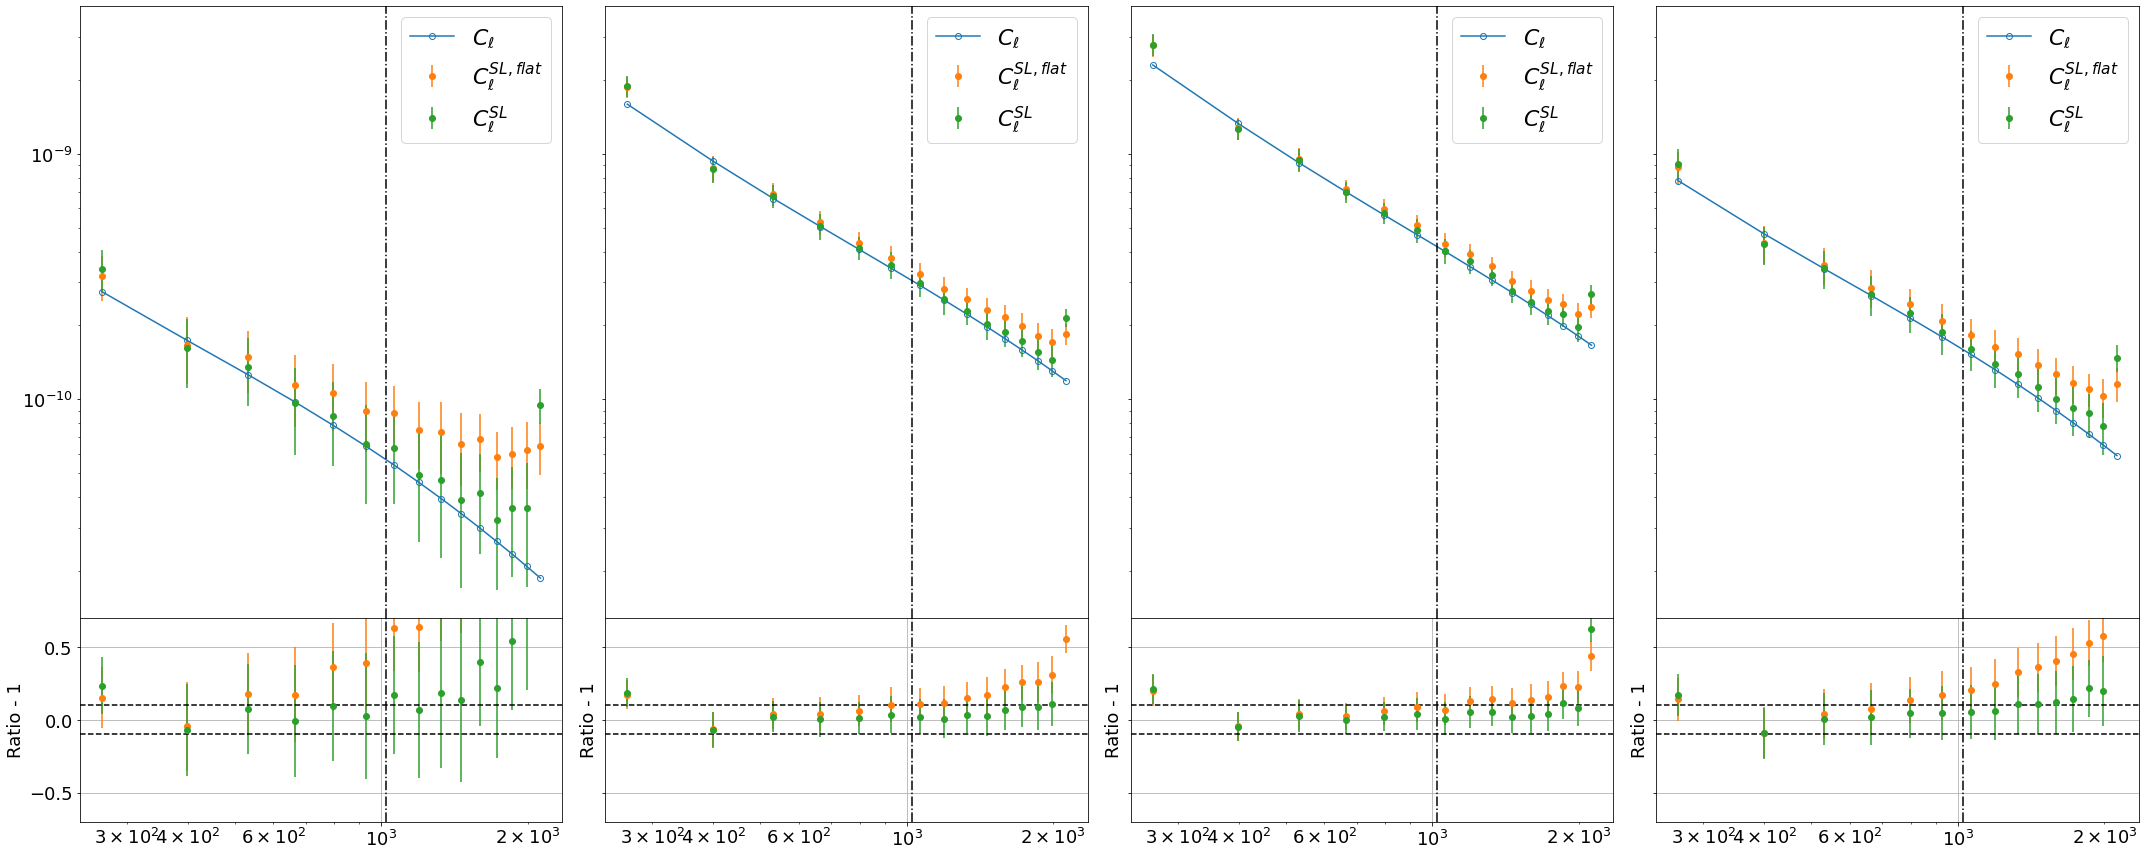

In [98]:
bc = 0.5 * (l_bins[1:] + l_bins[:-1])
fig = plt.figure(figsize=(30, 12))
fig, axs = plt.subplots(nrows=2, ncols=4, sharey='row', sharex=True,
                       gridspec_kw={'height_ratios': [3, 1], 'hspace': 0},
                       figsize=(30, 12))
for i in range(4):
    ax0, ax1 = axs[0, i], axs[1, i]
    ax0.errorbar(bc, cl_sl_binned_mean[i], cl_sl_binned_std[i], fmt='o', ls='None', label=r'$C_\ell^{SL, flat}$', c='C1')
    ax0.errorbar(bc, cl_sl_binned_mean_c[i], cl_sl_binned_std_c[i], fmt='o', ls='None', label=r'$C_\ell^{SL}$', c='C2')
    ax0.loglog(bc, cl_theory_binned[i], 'o', ls='-', label=r'$C_\ell$', c='C0', fillstyle='none')
    ax0.tick_params(axis='both', which='major', labelsize=18)
    ax0.tick_params(axis='both', which='minor', labelsize=18)
    ax0.axvline(nside, c='black', ls='-.')
    ax0.label_outer()
    ax0.legend(fontsize=22)
    
    ax1.errorbar(bc, cl_sl_binned_mean[i] / cl_theory_binned[i] - 1, cl_sl_binned_std[i] / cl_sl_binned_mean[i], fmt='o', c='C1')
    ax1.errorbar(bc, cl_sl_binned_mean_c[i] / cl_theory_binned[i] - 1, cl_sl_binned_std_c[i] / cl_sl_binned_mean_c[i], fmt='o', c='C2')
    #ax1.errorbar(bc, pcl_t_bb_binned[0][i] / cl_bb_binned[i] - 1, pcl_bb_binned_std[i] / pcl_t_bb_binned[0][i], fmt='o', c='green')
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.set_ylim(-0.7, 0.7)
    ax1.axhline(0.1, c='black', ls='--')
    ax1.axhline(-0.1, c='black', ls='--')
    ax1.set_ylabel('Ratio - 1', fontsize=18)
    ax1.axvline(nside, c='black', ls='-.')
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.tick_params(axis='both', which='minor', labelsize=18)
    #ax1.legend()
plt.tight_layout()

<Figure size 2160x864 with 0 Axes>

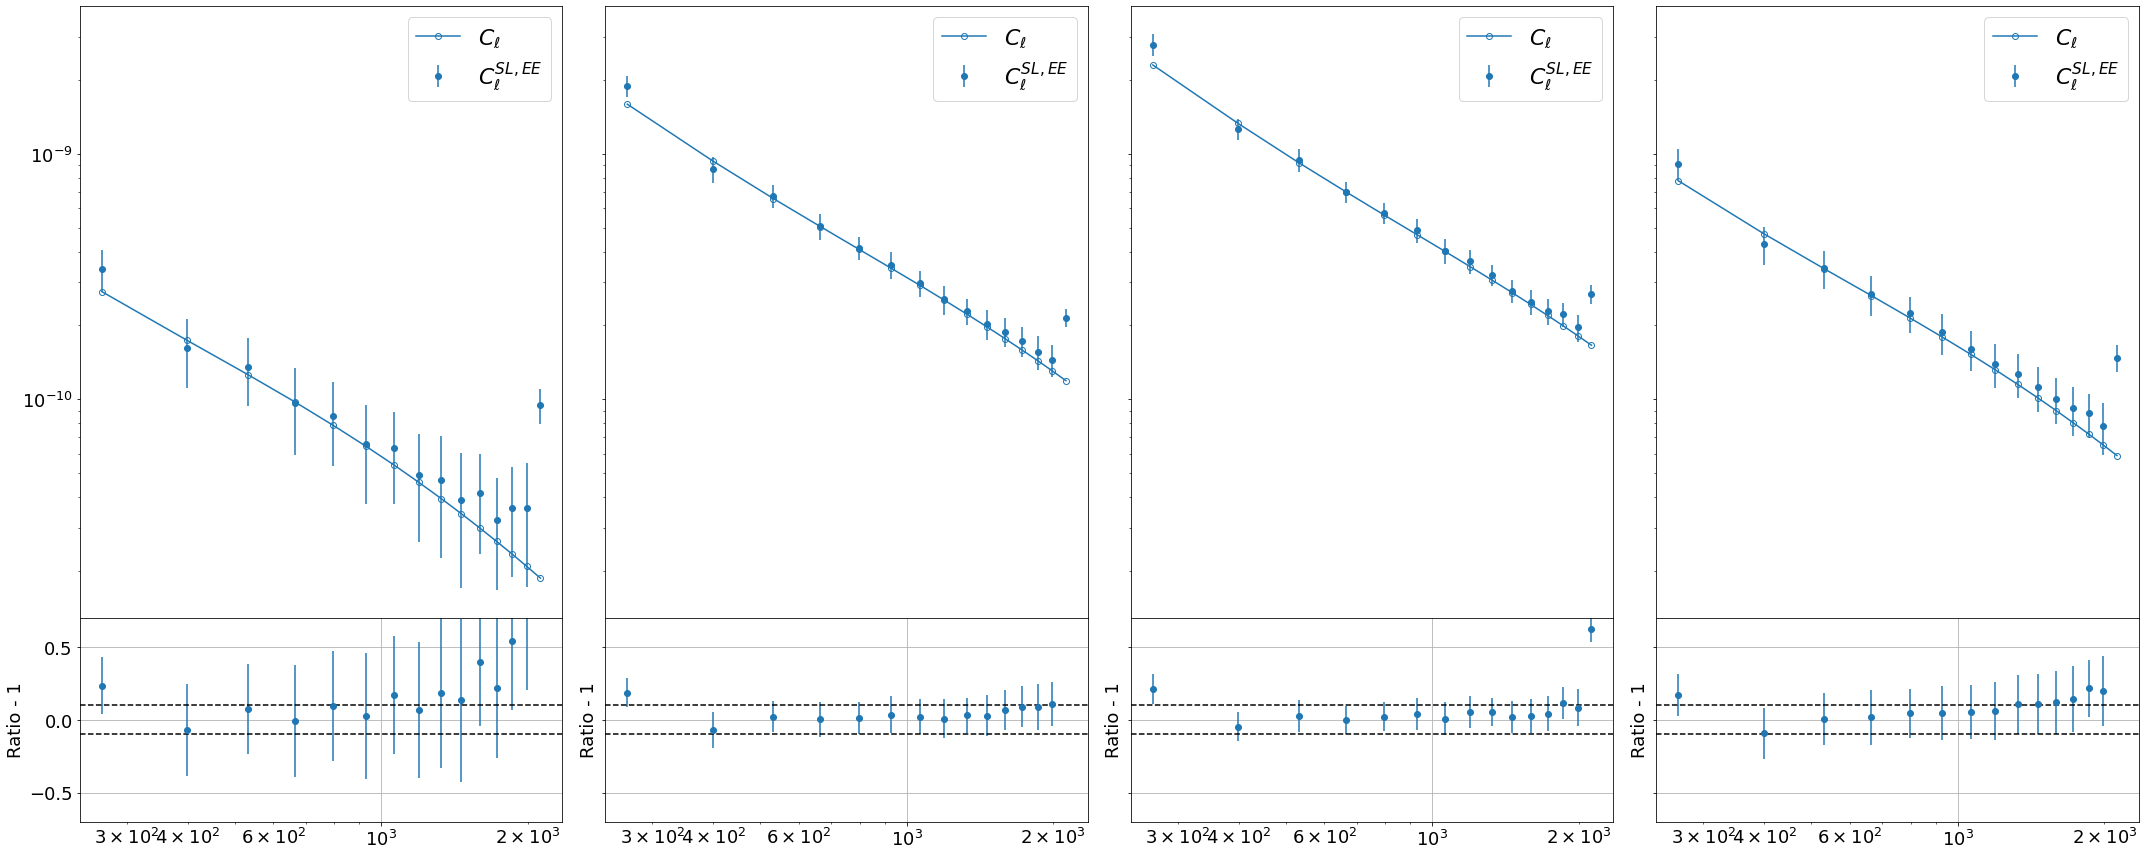

In [13]:
bc = 0.5 * (l_bins[1:] + l_bins[:-1])
fig = plt.figure(figsize=(30, 12))
fig, axs = plt.subplots(nrows=2, ncols=4, sharey='row', sharex=True,
                       gridspec_kw={'height_ratios': [3, 1], 'hspace': 0},
                       figsize=(30, 12))
for i in range(4):
    ax0, ax1 = axs[0, i], axs[1, i]
    ax0.errorbar(bc, cl_sl_binned_mean[i], cl_sl_binned_std[i], fmt='o', ls='None', label=r'$C_\ell^{SL, EE}$', c='C0')
    #ax0.errorbar(bc, pcl_bb_binned_mean[i], cv_bb[i], fmt='o', ls='None', label=r'$C_\ell^{SL, BB}$', c='C1')
    ax0.loglog(bc, cl_theory_binned[i], 'o', ls='-', label=r'$C_\ell$', c='C0', fillstyle='none')
    #ax0.errorbar(bc, pcl_t_bb_binned[0][i], pcl_bb_binned_std[i], fmt='o', ls='None', label=r'$C_\ell^{BB, SL}$', c='green')
    #ax0.loglog(bc, pcl_bb_binned_mean[i], 'v', label=r'$C_\ell^{BB, SL}$', c='green')
    #ax0.loglog(bc, cl_bb_binned[i], 'o', ls='-', label=r'$C_\ell^{BB}$', c='green', fillstyle='none')
    ax0.tick_params(axis='both', which='major', labelsize=18)
    ax0.tick_params(axis='both', which='minor', labelsize=18)
    ax0.label_outer()
    ax0.legend(fontsize=22)
    
    #ax1.semilogx(bc, pcl_bb_binned_mean[i] / cl_bb_binned[i] - 1, 'o', label='BB', c='green')
    #ax1.semilogx(bc, pcl_ee_binned_mean[i] / cl_ee_binned[i] - 1, 'v', label='EE', c='red')
    ax1.errorbar(bc, cl_sl_binned_mean[i] / cl_theory_binned[i] - 1, cl_sl_binned_std[i] / cl_sl_binned_mean[i], fmt='o', c='C0')
    #ax1.errorbar(bc, pcl_t_bb_binned[0][i] / cl_bb_binned[i] - 1, pcl_bb_binned_std[i] / pcl_t_bb_binned[0][i], fmt='o', c='green')
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.set_ylim(-0.7, 0.7)
    ax1.axhline(0.1, c='black', ls='--')
    ax1.axhline(-0.1, c='black', ls='--')
    ax1.set_ylabel('Ratio - 1', fontsize=18)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.tick_params(axis='both', which='minor', labelsize=18)
    #ax1.legend()
plt.tight_layout()